# Sello rojo

Libreta de análisis de los datos pertenecientes a la base de datos de la compañia Sello rojo para el año de 2017  

In [41]:
%matplotlib inline
import mysql.connector
import pandas as pd 
import numpy as np 
from gpcharts import figure
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import requests
import plotly.express as px
#from ipywidgets import interact, interact_manual, interactive

In [29]:
#conección a la base de datos 
mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    auth_plugin='mysql_native_password',
    passwd = "toor",
    db = "sello_rojo"
    )
print(mydb)

## Comenzamos a hacer uso de la conexión con la base

#### Comenzamos con una gráfica que nos muestre el total de las ventas por mes.

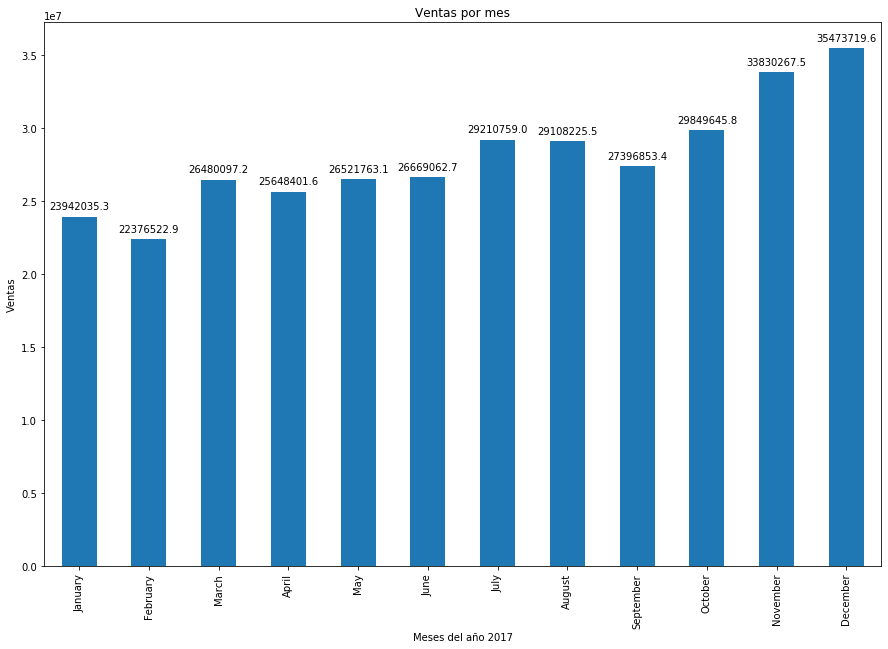

In [35]:
# "ventas"
ventas = df["ventas"]

#"etiquetas en el eje x"
x_labels = df["mes"].to_list()

# Plot the figure.
plt.figure(figsize=(15, 10))
ax = ventas.plot(kind='bar')
ax.set_title('Ventas por mes')
ax.set_xlabel('Meses del año 2017')
ax.set_ylabel('Ventas')
ax.set_xticklabels(x_labels)
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:     
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.1f}".format(y_value)
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)


In [42]:
#plt.figure(figsize=(7,7))
#plt.scatter(df["mes"], df["ventas"],)

gr = figure('Ventas por mes')
gr.ylabel="ventas"
gr.xlabel="meses del año 2017"
(gr.scatter(df["ventas"], trendline=True))

#### Como podemos ver en la gráfica anterior la tendencia de nuestras ventas es positiva.

#### A continuación veremos una predicción para los siguientes tres meses


In [8]:
meses = np.arange(1,13)
meses = meses.reshape(-1,1)
ventas = df["ventas"].to_numpy()
model = LinearRegression().fit(meses,ventas)
x_nuevo = np.array([13,14,15])
x_nuevo = x_nuevo.reshape(-1,1)
y_prediccion =model.predict(x_nuevo)
print("Las predicciones para ventas de los siguientes meses del año 2018 son:\nEnero:   {}\nFebrero: {}\nMarzo:   {}".format(y_prediccion[0],y_prediccion[1],y_prediccion[2]))

Las predicciones para ventas de los siguientes meses del año 2018 son:
Enero:   34236879.73590909
Febrero: 35189895.16297202
Marzo:   36142910.59003496


##### Pero sigamos viendo que más podemos descubrir, continuaremos encontrando aquellos productos que generaron  ventas mayores a 5 millones.




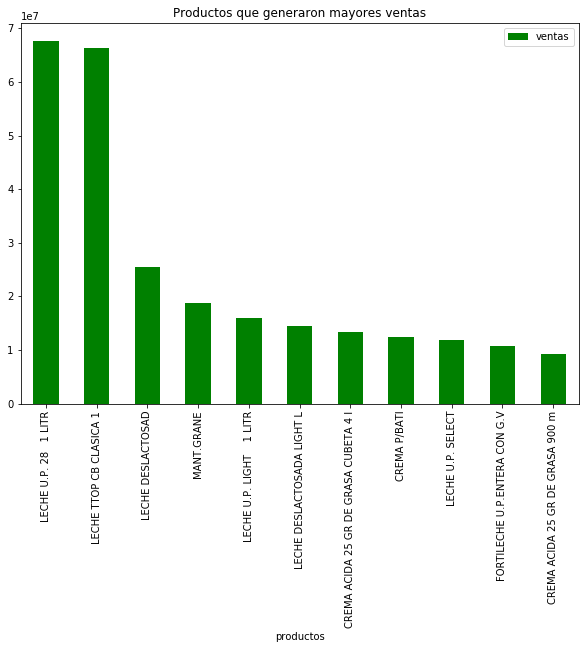

In [9]:
cursor.execute("SELECT * FROM ventas_prod")
df = pd.DataFrame(cursor)
df.columns = ["ventas","productos"]
df["ventas"] = df["ventas"].astype(float)
df.plot(kind="bar",x = "productos" ,title="Productos que generaron mayores ventas", colormap = "ocean",figsize=(10,7))

##### Continuemos con el número de ventas por estado registrado.

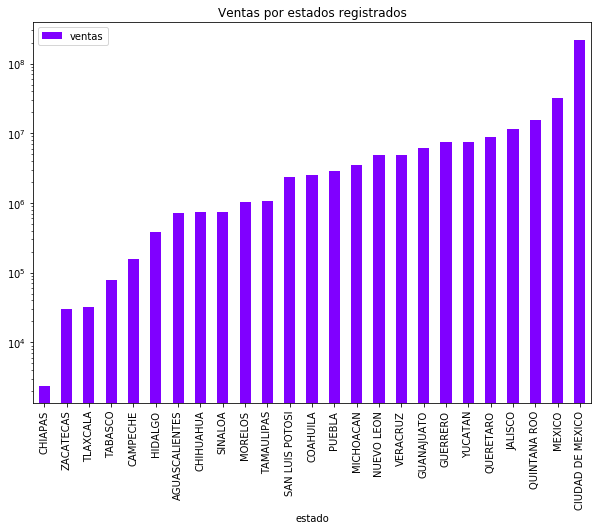

In [118]:
cursor.execute("SELECT * FROM ventas_estado")
df = pd.DataFrame(cursor)
df.columns = ["ventas","estado"]
df["ventas"] = df["ventas"].astype(float)
df.loc[23, 'estado'] = "MEXICO"
df.loc[24, 'estado'] = "CIUDAD DE MEXICO" 
df.plot(kind="bar",x = "estado" ,title="Ventas por estados registrados", colormap = "rainbow",logy = True ,use_index = True,figsize=(10,7))


Para la gráfica anterior **tomar en cuenta la escala** ya que va siendo modificada para poder ver todas las columnas ya que la columna del Distrito Federal se aleja mucho del resto.

In [119]:
repo_url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json' #Archivo GeoJSON
mx_regions_geo = requests.get(repo_url).json()

In [120]:
a,b = 'áéíóúüñÁÉÍÓÚÜÑ','aeiouunAEIOUUN'
trans = str.maketrans(a,b)
for i in mx_regions_geo['features']:
    i['properties']['name']= i['properties']['name'].translate(trans).upper()
   

In [121]:
fig = px.choropleth(data_frame=df, 
                    geojson=mx_regions_geo, 
                    locations='estado', # nombre de la columna del Dataframe
                    featureidkey='properties.name',  # ruta al campo del archivo GeoJSON con el que se hará la relación (nombre de los estados)
                    color='ventas', #El color depende de las cantidades
                    color_continuous_scale="greens", 
                    scope="north america"
                   )
fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")

fig.update_layout(
    title_text = 'Ventas por estados registrados',
    font=dict(
        #family="Courier New, monospace",
        family="Ubuntu",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

### Las siguientes graficas muestran los 5 productos que más se vendieron en los 6 estados que registraron mayores ventas 

In [11]:
cursor.execute("SELECT * FROM prod_est")
df = pd.DataFrame(cursor)
df.columns = ["ventas","SKU","estado"]
df["ventas"] = df["ventas"].astype(float)
graf = figure("r")
graf.ylabel = 'Estados'
estados = pd.unique(df["estado"]).tolist()
#x[0:0]=["estados"]
def dibujar(plt, aux,estado):
    plt.barh(aux["SKU"], width = aux["ventas"], align = "edge",color = "y")
    plt.set_xlabel("ventas")
    plt.set_ylabel("productos")
    plt.set_title(estado)

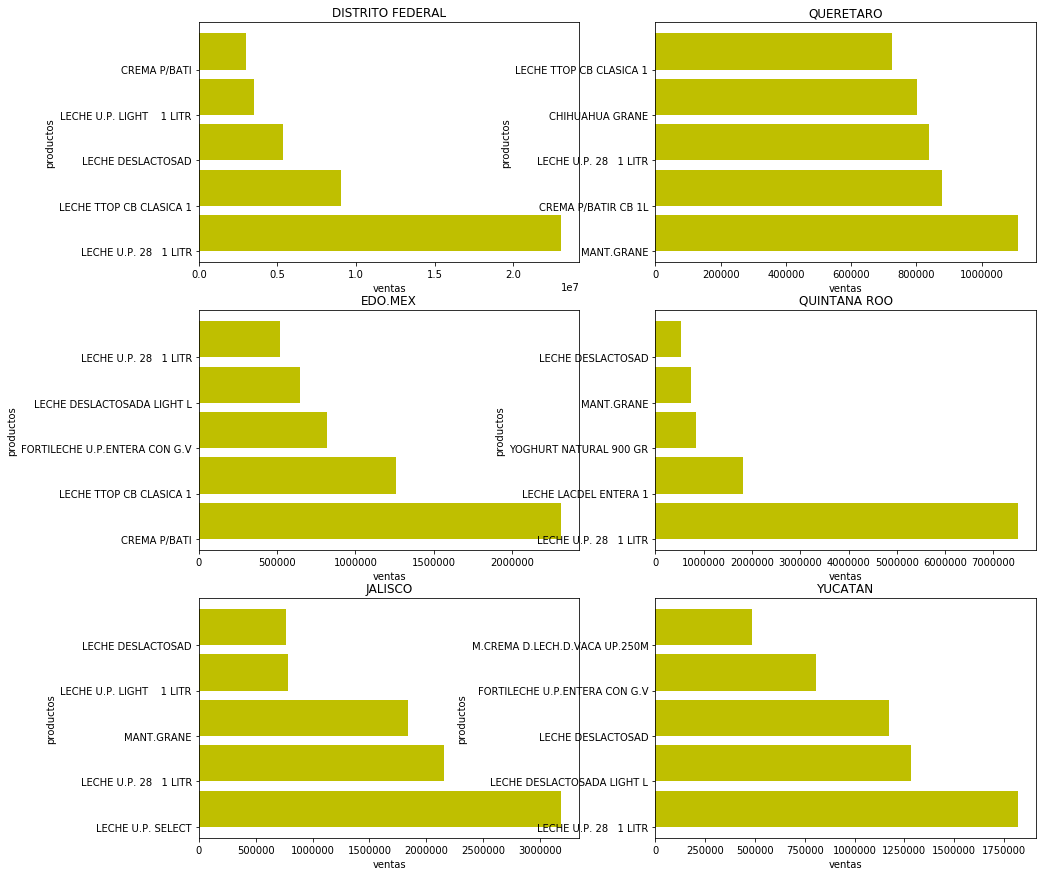

In [12]:
fig, axs = plt.subplots(3, 2,figsize=(15,15))
x = 0
y = 0
for estado in estados:
    aux = df[df['estado'] == estado ][['SKU','ventas']]
    dibujar(axs[x,y],aux,estado)
    x = x + 1
    if x > 2:
        x = 0
        y = y +1
    

#### A continuación se muestra el top 10 de cadenas que generaron más compras y el top 10 de las que generaron menos

In [14]:
cursor.execute("SELECT * FROM cad")
df = pd.DataFrame(cursor)
df.columns = ["ventas","cadena"]
df["ventas"] = df["ventas"].astype(float)


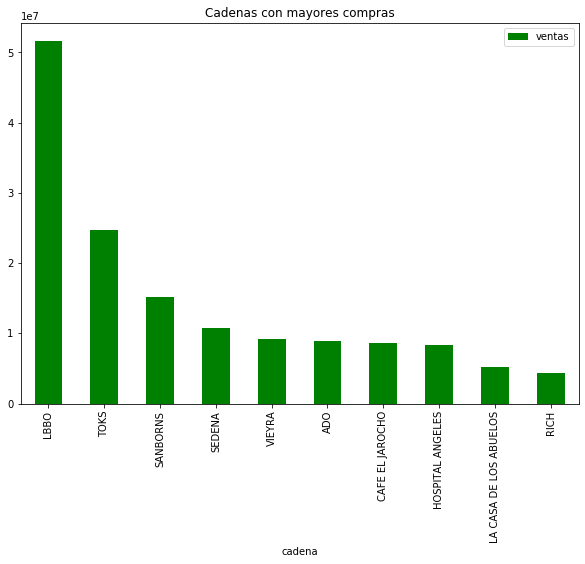

In [21]:
cad_max = df.head(10)
cad_min = df.tail(10)
cad_max.plot(kind="bar",x = "cadena" ,title="Cadenas con mayores compras",figsize=(10,7), color="g")

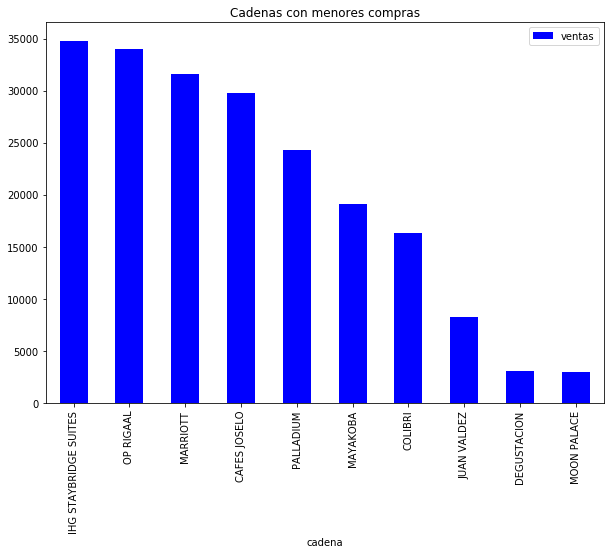

In [24]:
cad_min.plot(kind="bar",x = "cadena" ,title="Cadenas con menores compras",figsize=(10,7), color="b")

In [37]:
cursor.execute("SELECT * FROM cad_estado")
df = pd.DataFrame(cursor)
df.columns = ["ventas","cadena","estado"]
df["ventas"] = df["ventas"].astype(float)
graf = figure("Cadenas por estado")
graf.ylabel = 'Estados'
estados = pd.unique(df["estado"]).tolist()
#x[0:0]=["estados"]
def dibujar(plt, aux,estado):
    plt.barh(aux["cadena"], width = aux["ventas"], align = "edge",color = "y")
    plt.set_xlabel("Ventas")
    plt.set_ylabel("Cadenas")
    plt.set_title(estado)

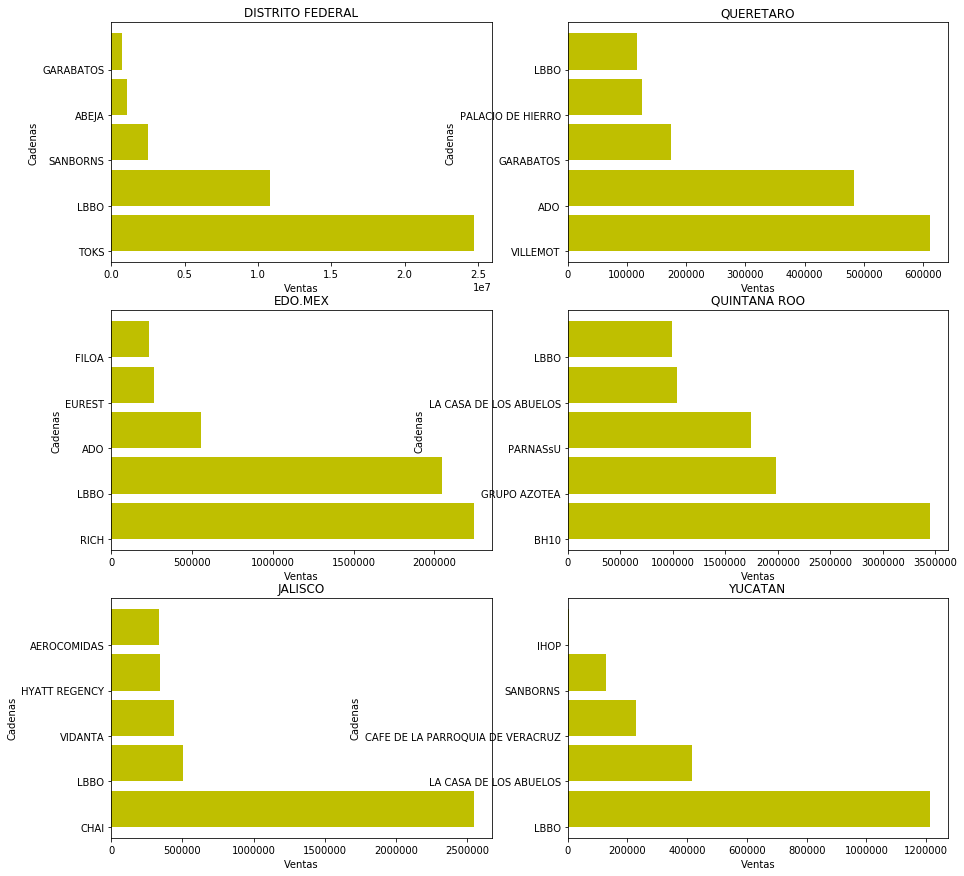

In [39]:
fig, axs = plt.subplots(3, 2,figsize=(15,15))
x = 0
y = 0
for estado in estados:
    aux = df[df['estado'] == estado ][['cadena','ventas']]
    dibujar(axs[x,y],aux,estado)
    x = x + 1
    if x > 2:
        x = 0
        y = y +1

In [25]:
mydb.close()